# Multi-outputs BERT Model with HuggingFace transformer library, using TensorFlow compatible models.

## Imports

In [57]:
# Base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Tensorflow
import tensorflow as tf
import tensorflow_text as tf_text
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.utils import to_categorical

# Huggingface
from transformers import TFBertModel,  BertConfig, BertTokenizerFast

# Custom
from helper_functions import load_sst_dataset, plot_model_history, save_ts_model

## Configuration

In [44]:
# Force the use of offline files for huggingface
# https://huggingface.co/transformers/installation.html
# %env TRANSFORMERS_OFFLINE=1
# %env HF_DATASETS_OFFLINE=1

# Force the use of the CPU instead of the GPU if running out of GPU memory
#my_devices = tf.config.experimental.list_physical_devices(device_type='CPU')
#tf.config.experimental.set_visible_devices(devices= my_devices, device_type='CPU')
device = '/CPU:0' # input '/CPU:0' to use the CPU or '/GPU:0' for the GPU

# Model to be used
model_name = 'bert-base-uncased'                    # full standard Bert

# Tokenizing parameters
max_length = 60    # Max length of an input

# Training parameters
epochs = 1  # 1 is enough for code testing

## Load the data

In [45]:
text_train, Y1, Y2, text_test, Y1_test, Y2_test = load_sst_dataset()

100%|██████████| 3/3 [00:00<00:00, 596.49it/s]


## Load a BERT model from HuggingFace library

In [48]:
# Load the configuration from the model
with tf.device(device):
  config = BertConfig.from_pretrained(model_name)

  # We don't need the output of the hidden layers
  config.output_hidden_states = False

  # Load BERT tokenizer
  tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

  # Load the Transformers BERT model
  encoder = TFBertModel.from_pretrained(model_name, config = config, from_pt=from_pt)

DEBUG:filelock:Attempting to acquire lock 2686501633856 on C:\Users\thiba/.cache\huggingface\transformers\f55082bb509cfd3585c1d6e383f529197f03fce817374e4edf03306593ef4c16.8198c2ba6b951372d5ca981b940a059b96ebbb3c514469a2aae7636fa05eb25e.lock
DEBUG:filelock:Lock 2686501633856 acquired on C:\Users\thiba/.cache\huggingface\transformers\f55082bb509cfd3585c1d6e383f529197f03fce817374e4edf03306593ef4c16.8198c2ba6b951372d5ca981b940a059b96ebbb3c514469a2aae7636fa05eb25e.lock
Downloading: 100%|██████████| 847/847 [00:00<00:00, 423kB/s]
DEBUG:filelock:Attempting to release lock 2686501633856 on C:\Users\thiba/.cache\huggingface\transformers\f55082bb509cfd3585c1d6e383f529197f03fce817374e4edf03306593ef4c16.8198c2ba6b951372d5ca981b940a059b96ebbb3c514469a2aae7636fa05eb25e.lock
DEBUG:filelock:Lock 2686501633856 released on C:\Users\thiba/.cache\huggingface\transformers\f55082bb509cfd3585c1d6e383f529197f03fce817374e4edf03306593ef4c16.8198c2ba6b951372d5ca981b940a059b96ebbb3c514469a2aae7636fa05eb25e.lock
Y

## Tokenize the text

In [49]:
# Use Hugging Face tokenizer loaded before
def tokenize(t):
    """ Shared configuration for the tokenizer """
    return tokenizer(
        text=t,
        add_special_tokens=True,
        max_length=max_length,
        truncation=True,
        padding=True, 
        return_tensors='tf',
        return_token_type_ids = True,
        return_attention_mask = True,
        verbose = True)

# Tokenize the train and test texts
X = tokenize(text_train)
X_test = tokenize(text_test)

In [50]:
# TF Keras documentation: https://www.tensorflow.org/api_docs/python/tf/keras/Model

# Create model function
def create_model():

    # Build your model input
    input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
    token_type_ids = Input(shape=(max_length,), name="token_type_ids", dtype='int32')
    attention_mask = Input(shape=(max_length,), name='attention_mask', dtype='int32')
    
    inputs = {
        'input_ids': input_ids, 
        'token_type_ids':token_type_ids, 
        'attention_mask': attention_mask
        }

    
    # BERT, loading the model
    # Extract the Bert layers from the encoder loaded before
    bert_model = encoder(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[1]
    # If we don't want to fine tune the Bert model on the dataset, then we force to weight to stay constant
    bert_model.trainable = False
    
    # Dropout layer
    dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
    pooled_output = dropout(bert_model, training=False)
    
    # Then build the model output
    Y1_output = Dense(1, name='Y1')(pooled_output)
    Y2_output = Dense(units=1, kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='Y2')(pooled_output)
    
    outputs = {'Y1': Y1_output, 'Y2': Y2_output}

    # Define the model
    model = Model(inputs=inputs, outputs=outputs, name='Multi-output_BERT')

    # Set an optimizer
    optimizer = Adam(
        learning_rate=5e-05,
        epsilon=1e-08,
        decay=0.01,
        clipnorm=1.0)

    # Set loss functions
    loss = {
        'Y1': tf.keras.losses.MeanSquaredError(),    # loss for a continuous variable
        'Y2': BinaryCrossentropy(),                  # loss for a binary categorical variable
        }

    # Set metrics    
    metric = {
        'Y1': tf.keras.metrics.MeanSquaredError('mse'),
        'Y2': BinaryAccuracy('accuracy')
        }

    # Compile the model
    model.compile(
        optimizer = optimizer,
        loss = loss, 
        metrics = metric)

    return model


# Create the model
with tf.device(device):
    model = create_model()
    
# Take a look at the model
model.summary()

Model: "Multi-output_BERT"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 60)]         0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 60)]         0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 60)]         0                                            
__________________________________________________________________________________________________
tf_bert_model_3 (TFBertModel)   TFBaseModelOutputWit 54025728    input_ids[0][0]                  
                                                                 attention_mask[0]

## Train the model

In [51]:
# Training input
x = {'input_ids': X['input_ids'], 'token_type_ids': X['token_type_ids'], 'attention_mask': X['attention_mask']}
# print(x)

# Training output
y = {'Y1': Y1, 'Y2': Y2}
# print(y)

In [52]:
# Fit the model
with tf.device(device):
    history = model.fit(
        x=x,
        y=y,
        validation_split=0.2,
        batch_size=64,
        epochs=epochs,
        )

107/107 [==============================] - 2446s 23s/step - loss: 6.5228 - Y1_loss: 0.2920 - Y2_loss: 6.2308 - Y1_mse: 0.2920 - Y2_accuracy: 0.5832 - val_loss: 12.5786 - val_Y1_loss: 0.0955 - val_Y2_loss: 12.4831 - val_Y1_mse: 0.0955 - val_Y2_accuracy: 0.1814


## Test the model

In [53]:
# Run evaluation
with tf.device(device):
    model_eval = model.evaluate(
        x={'input_ids': X_test['input_ids'], 'token_type_ids': X_test['token_type_ids'], 'attention_mask': X_test['attention_mask']},
        y={'Y1': Y1_test, 'Y2': Y2_test}
    )

104/104 [==============================] - 404s 4s/step - loss: 7.9035 - Y1_loss: 0.0693 - Y2_loss: 7.8342 - Y1_mse: 0.0693 - Y2_accuracy: 0.4863


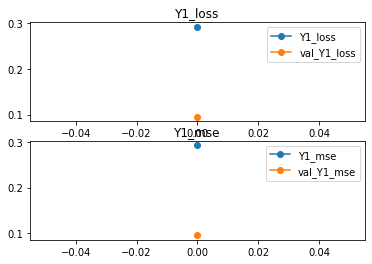

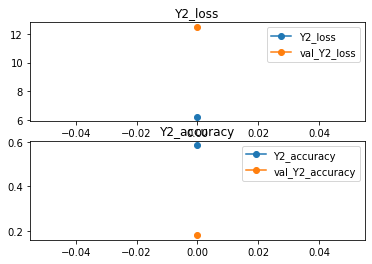

In [54]:
plot_model_history('Y1_loss','Y1_mse')
plot_model_history('Y2_loss','Y2_accuracy')

## Export to tensorflow.js

In [ ]:
save_ts_model(model,epochs,model_name)